In [2]:
import os
import sys

import pydicom
import matplotlib.pyplot as plt

from tcia_utils import nbia
from monai.transforms import (
    LoadImage,
    Orientation,
    EnsureChannelFirst,
    Compose,
)


In [3]:
project_environment_directory = os.path.abspath(sys.prefix)
project_directory = os.path.dirname(project_environment_directory)
data_directory = os.path.join(project_directory, "data")

if not os.path.exists(data_directory):
    print("Data directory does not exist, new data directory created.")
    os.mkdir(data_directory)

    print(data_directory)

#### Download a CT image from NBIA 

In [12]:
cart_name = "nbia-11691699875980971"
cart_data = nbia.getSharedCart(cart_name)
print("Downloading series...")
dataframe = nbia.downloadSeries(cart_data, format="df", path=data_directory)

2023-11-13 17:20:26,571:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-11691699875980971'}
2023-11-13 17:20:28,331:INFO:Downloading 2 Series Instance UIDs (scans).
2023-11-13 17:20:28,332:INFO:Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.3320.3273.147727698049157996140705051331


2023-11-13 17:20:32,007:INFO:Downloading... https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?NewFileNames=Yes&SeriesInstanceUID=1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668
2023-11-13 17:23:24,348:INFO:Downloaded 2 out of 2 Series Instance UIDs (scans).
0 failed to download.
0 previously downloaded.


In [4]:
ct_series_directory = os.path.join(
    data_directory, "1.3.6.1.4.1.14519.5.2.1.3320.3273.193828570195012288011029757668"
)

#### Read a dicom file using **pydicom** 

In [5]:
ds = pydicom.read_file(os.path.join(ct_series_directory, "1-390.dcm"))
# ds

In [6]:
image = ds.pixel_array
image.shape

(512, 512)

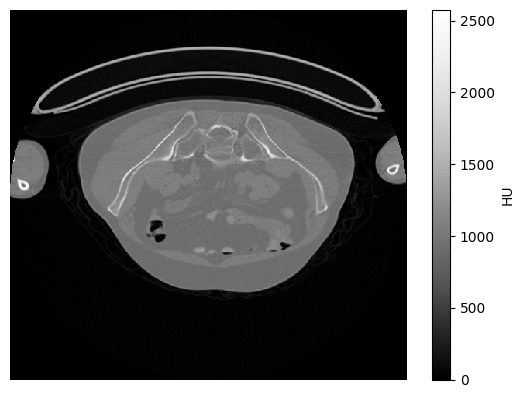

In [7]:
# Plotted pixeldata without HU scaling
plt.pcolormesh(image, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis("off")
plt.show()

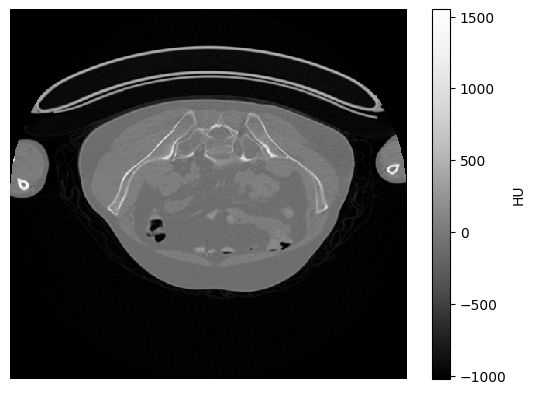

In [8]:
#  Plotted pixeldata with HU scaling for standardisation
rescaled_image = ds.RescaleSlope * image + ds.RescaleIntercept

plt.pcolormesh(rescaled_image, cmap="Greys_r")
plt.colorbar(label="HU")
plt.axis("off")
plt.show()

#### Load image using MONAI LoadImage API 

In [ ]:
image_loader = LoadImage(image_only=True)
ct_image = image_loader(ct_series_directory)

In [86]:
ct_image # pytorch like tensor

metatensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

        [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],

        [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024.

In [87]:
ct_image.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-249.51171875, -401.01171875, 1937.0]},
 '00280030': {'vr': 'DS', 'Value': [0.9765625, 0.9765625, 2.0]},
 'spacing': array([0.9765625, 0.9765625, 2.       ]),
 'lastImagePositionPatient': array([-249.51171875, -401.01171875,  -11.        ]),
 spatial_shape: (512, 512, 975),
 space: RAS,
 original_affine: array([[-9.76562500e-01,  0.00000000e+00,  0.00000000e+00,
          2.49511719e+02],
        [ 0.00000000e+00, -9.76562500e-01,  0.00000000e+00,
          4.01011719e+02],
        [ 0.00000000e+00,  0.00000000e+00, -2.00000000e+00,
          1.93700000e+03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-9.7656e-01,  0.0000e+00,  0.0000e+00,  2.4951e+02],
         [ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.0101e+02],
         [ 0.0000e+00,  0.0000e+00, -2.0000e+00,  1.9370e+03],
         [ 0.0000e+00,  0.0000e+00,  0.0000e

In [88]:
ct_image.shape[0]

512

In [ ]:
# slice_position = int(ct_image.shape[1] / 2) # Central slice
slice_position = 256 # Central slice
ct_coronal_slice = ct_image[:,slice_position].cpu().numpy()

# slice_position

In [11]:
def plot_coronal_slice(slice):
	plt.figure(figsize=(3, 8))
	plt.pcolormesh(slice.T, cmap="Greys_r")
	plt.colorbar(label="HU")
	plt.axis("off")
	plt.show()

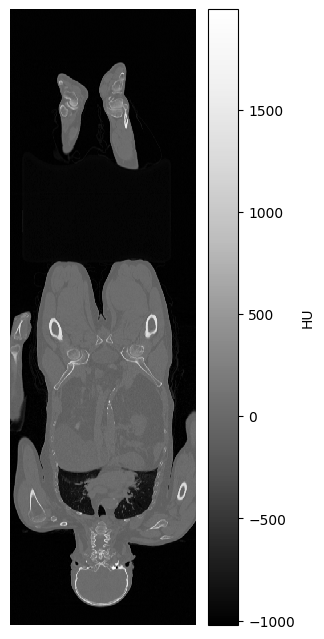

In [91]:
plot_coronal_slice(ct_coronal_slice)

In [92]:
# Create a channel dimension

channel_transform = EnsureChannelFirst()
ct_image = channel_transform(ct_image)
ct_image.shape

torch.Size([1, 512, 512, 975])

In [93]:
orientation_transform = Orientation(axcodes=("LPS"))

ct_image = orientation_transform(ct_image)

In [99]:
transformed_ct_coronal_slice = ct_image[0, :, slice_position].cpu().numpy()

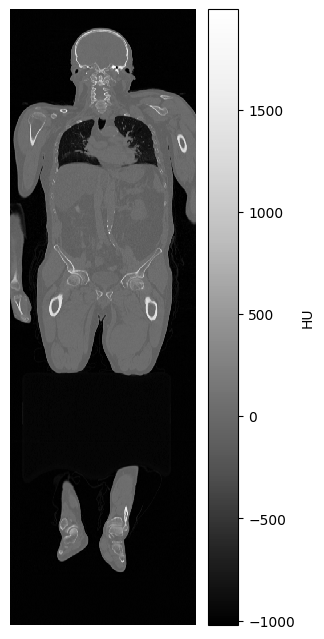

In [100]:
plot_coronal_slice(transformed_ct_coronal_slice)

#### Create a preprocessing pipeline 

In [12]:
preprocessing_pipeline = Compose([
	LoadImage(image_only=True),
	EnsureChannelFirst(),
	Orientation(axcodes=("LPS"))
])

In [13]:
preprocessed_ct_image = preprocessing_pipeline(ct_series_directory)
preprocesssed_ct_coronal_slice = (
    preprocessed_ct_image[0, :, slice_position].cpu().numpy()
)

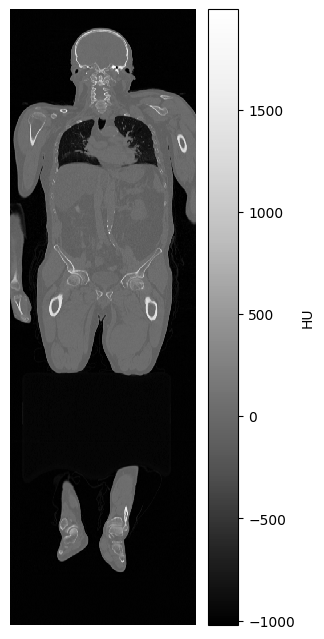

In [14]:
plot_coronal_slice(preprocesssed_ct_coronal_slice)